In [ ]:
import os
import sys
import time
import datetime
import re
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline
from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform
output_notebook()



In [2]:
chan_ind = ['0','3','5']
channel = ['Brightfield', 'mScarlet', 'sfCFP']
chan_dict = dict(zip(chan_ind, channel))

# epoch_zero = 1518161340

def img_metadata_dict(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    metadata_str = img.tag_v2[metadata_key].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata = img_metadata_dict(img)
    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def fn_metadata(fn):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    with Image.open(fn) as img:
        out = img_metadata(img)
    return out

def get_time_vector_from_fn(fn):
    time_dict = dict(zip(channel,len(channel)*[]))
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[chan_dict[ch]].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = dict(zip(channel,len(channel)*[]))
    time_dict = dict(zip(channel,len(channel)*[]))
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            ch = chan_dict[ch]
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = int(os.path.basename(fn).split("_")[1])
                    h, w = im_arr.shape
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
#                     ch = chan_dict[ch]
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    metadata_str = img.tag_v2[50839].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple)

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Make the structuring element
    selem = skimage.morphology.square(2)
    # Perform the median filter
    im_filt = skimage.filters.median(im_arr, selem)

    # Convert the uneven image to floating point
    im_float = im_filt / 4096
    # Smooth to reduce noise
    g_radius = 10
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_bgsub)
    im_edge = skimage.exposure.equalize_adapthist(im_edge)

    # Remove small objects and fill holes
    thresh = skimage.filters.threshold_otsu(im_edge)
    im_bw = ndi.morphology.binary_fill_holes(im_edge > thresh)
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)

    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(img):
    im_labeled, num = label_image(img[:,:,2])
    gfp, rfp = crop(img[:,:,1]), crop(img[:,:,0])
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    h, w = gfp.shape
    x1,x2,y1,y2 = np.int(7*w/8),w,0,np.int(1*h/8)
    gfp_bg = np.mean(gfp[y1:y2,x1:x2])
    rfp_bg = np.mean(rfp[y1:y2,x1:x2])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def get_fluors(rfp, gfp, im_labeled):
#     im_labeled, num = label_image(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    

In [ ]:
i = 2
fn = "/mnt/disks/timelapse-movies/180320/20180320_fullcircuit_longpads_1/Pos7/img_000000057_0_000.tif"
with Image.open(fn) as img:
#     print(f_names[i])
    _, _, im_arr = get_data_from_frame(img)
    im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
#     im_arr = im_arr.astype(np.float32).astype(np.uint16)
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
#     im_arr[800:830,190:210]=im_arr.mean()
#     im_arr = im_arr[200:400,200:400]
#     im_arr = im_arr / im_arr.mean()
    w, h = im_arr.shape

    # Make the structuring element
    selem = skimage.morphology.square(2)
    # Perform the median filter
    im_filt = skimage.filters.median(im_arr, selem)

    # Convert the uneven image to floating point
    im_float = im_filt / 4096
    # Smooth to reduce noise
    g_radius = 10
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    thresh_factor = 0.3
    
    # threshold
#     im_boxed = im_bgsub > thresh_factor*im_bgsub.max()

    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_bgsub)
    im_edge = skimage.exposure.equalize_adapthist(im_edge)
#     im_edge = skimage.filters.gaussian(im_edge, 4)

    # Remove small objects and fill holes
    thresh = skimage.filters.threshold_otsu(im_edge)
#     selem = skimage.morphology.square(1)
    im_bw = ndi.morphology.binary_fill_holes(im_edge > thresh)#, selem)
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)

    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    plt.imshow(im_labeled)
    print(im_arr.dtype)
    print(num)

titles = ("im_arr", "im_filt", "im_bgsub", "im_adj", "im_edge", "im_bw", "im_labeled>0")
plots = (im_arr, im_filt, im_bgsub, im_adj, im_edge>thresh, im_bw, im_labeled>0)
for im, title in zip(plots, titles):
    plt.figure(figsize=(7,7))
    plt.imshow(im)
    plt.title(title)

plt.figure()
_ = plt.hist(im_edge.flatten(), bins=200)

In [ ]:
skimage.filters.threshold_otsu(im_edge)

In [ ]:
top_folder = "/mnt/disks/timelapse-movies/180320/20180320_fullcircuit_longpads_1"
img_dirs = np.sort([os.path.join(top_folder,x) for x in os.listdir(top_folder) if os.path.isdir(os.path.join(top_folder,x))])
f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs for fn in os.listdir(img_dir) if '.tif' in fn[-4:] if 'convert' not in fn]
# p3_names = [f_n for f_n in f_names if "Pos3" in f_n]

# concat_img_files(f_names[::40], 'test_out.tif')

def make_masks(fn_list, fn_out):
    template = "/mnt/disks/timelapse-movies/180320/20180320_fullcircuit_longpads_1/Pos{}/img_{:09d}_0_000.tif"
    save_tmp = "/home/jmp/git/omnitray-modeling/omnitray-modeling/mask_images/mask_pos{}_t{}.tif"
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    t_skip = 1
    t_points = np.arange(0,100,t_skip)
    t_len = len(t_points)
    c_points = [0,3,5]
    p_skip = 1
    p_points = np.arange(0,9,p_skip)
    p_len = len(p_points)
    def par_worker(t_vec):
        for t_i in t_vec:
            for p_i in p_points:
                fn_out = save_tmp.format(p_i, t_i)
                fn = template.format(p_i, t_i)
                with Image.open(fn) as img:
                    _, _, im_arr = get_data_from_frame(img)
                im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
                im_arr = im_arr.astype(np.float32).astype(np.uint16)
                im_lab, num = label_image(im_arr)
                with TiffWriter(fn_out) as tif:
                    tif.save(im_lab)
    
    jobs = []
    for i in [0,1,2,3]:
        p = multiprocessing.Process(target=par_worker, 
                                    args=(im_all[i::4,:,:,:,:].copy(), 
                                    t_df.time[i::4].values, fn_outs[i]))
        jobs.append(p)
        p.start()
    for j in jobs:
        j.join()
    print("Done!")
    
    for tp in t_points:
        for pp in p_points:
            
            
make_movie(f_names, '180320_fullmovie_masktry.tif')

In [ ]:
top_folder = "/mnt/disks/timelapse-movies/180320/20180320_fullcircuit_longpads_1"
img_dirs = np.sort([os.path.join(top_folder,x) for x in os.listdir(top_folder) if os.path.isdir(os.path.join(top_folder,x))])
f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs for fn in os.listdir(img_dir) if '.tif' in fn[-4:] if 'convert' not in fn]
# p3_names = [f_n for f_n in f_names if "Pos3" in f_n]

# concat_img_files(f_names[::40], 'test_out.tif')

def make_movie(fn_list, fn_out):
    template = "/mnt/disks/timelapse-movies/180320/20180320_fullcircuit_longpads_1/Pos{}/img_{:09d}_{}_000.tif"
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    t_skip = 1
    t_points = np.arange(0,100,t_skip)
    t_len = len(t_points)
    c_points = [0,3,5]
    p_skip = 1
    p_points = np.arange(0,9,p_skip)
    p_len = len(p_points)
    im_out = np.zeros((t_len,p_len,4,2048//2,2048//2,1), dtype=np.uint16)
    with TiffWriter(fn_out, imagej=True, append=False) as tif:
        for tp in t_points:
            for pp in p_points:
                for cp in c_points:
                    fn = template.format(pp,tp,cp)
                    eof_flag = True
                    print("Writing ", fn)
                    with Image.open(fn) as img:
                        while eof_flag:
                            _, _, im_arr = get_data_from_frame(img)
                            im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
                            im_arr = im_arr.astype(np.float32).astype(np.uint16)
                            img_md = img_metadata_dict(img)
                            for k in keep_keys:
                                metadata[k] = img_md[k]
                            h, w = im_arr.shape
                            im_out[tp//t_skip, pp//p_skip, cp//2, :, :, 0] = im_arr
                            try:
                                i += 1
                                img.seek(img.tell()+1)
                            except:
                                eof_flag = False
                lab, num = label_image(im_out[tp//t_skip, pp//p_skip, 0, :, :, 0])
                im_out[tp//t_skip, pp//p_skip, 3, :, :, 0] = lab.astype(np.uint16)
        tif.save(im_out, metadata=metadata.copy())

make_movie(f_names, '180320_fullmovie_masktry.tif')

In [ ]:
x=40
dif = 0
def filt(img):
#     selem = skimage.morphology.square(1)
#     # Perform the median filter
#     return skimage.filters.median(img, selem)
    return skimage.filters.gaussian_filter(img, 10)

plt.figure(figsize=(10,10))
# plt.imshow(filt(im_all[x,2,0,:,:]/(2**16))-filt(im_all[x-dif,2,0,:,:]/(2**16)))
plt.imshow(im_all[x,2,0,:,:]/(2**16)-filt(im_all[x-dif,2,0,:,:]/(2**16)))
plt.figure(figsize=(10,10))
plt.imshow(im_all[x,2,0,:,:])


plt.figure(figsize=(10,10))
# plt.imshow(filt(im_all[x,2,0,:,:]/(2**16))-filt(im_all[x-dif,2,0,:,:]/(2**16)))
plt.imshow(label_image(im_all[x,2,0,:,:]/(2**16)-filt(im_all[x-dif,2,0,:,:]/(2**16)))[0])


In [ ]:
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(img, skip=10, pos=3):
    plt.close('all')
    
    t_points, s, c, h, w = img.shape
    t_vec = np.arange(0, t_points, skip)
    frames = len(t_vec)
    #t_list = list(t_vec[-1::-1]) + [-1]
    
    t_list = np.arange(t_points)
    
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    im_list = [0,0,0,0]
    
    # initialize plots
    titles = ['bf', 'mscarlet', 'sfcfp', 'lab']
    vmaxs = [2.8e4  , 5e2, 4e2, 1]
    vmins = [1e4, 1e2, 1e2, 0]
    for i in np.arange(4):
        ax = axs[i//2, np.mod(i,2)]
        indxs = [i]
        vmax = vmaxs[i]
        vmin = vmins[i]
        im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
        cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i])
        im_list[i] = im
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w))
    def animate(i):
        # Plot 
        for j in np.arange(4):
            ax = axs[j//2, np.mod(j,2)]
            frame_arr = img[i*skip,pos,j,:,:]#.sum(axis=0)
            im_list[j].set_array(frame_arr)

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=frames)


    # Set up formatting for the movie files
    #Writer = anm.writers['ffmpeg_file']
    #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
#     im_all = img.asarray()
anim = write_movie(im_all, skip=1, pos=0)
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(im_all, skip=1, pos=4)
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(im_all, skip=1, pos=5)
HTML(anim.to_html5_video())

In [ ]:
import matplotlib.animation as anm
from IPython.display import HTML

with skimage.external.tifffile.TiffFile('180320_fullmovie.tif') as img:
    print(img.info())
    im_all = img.asarray()
#     im_arr = np.concatenate([img.asarray(series=i) for i in range(2)], axis=0)

# t, h, w = im_arr.shape
# t = t // 3
# s = 3
# im_all = np.ndarray((t, h, w, 3), dtype=np.uint16)
# for i in range(3):
#     im_all[:, :, :, i] = im_arr[i::3, :, :]
# anim = write_movie(im_all, skip=50)
# HTML(anim.to_html5_video())

In [ ]:
im_all.shape
# anim = write_movie(im_all, skip=40)
# HTML(anim.to_html5_video())

In [ ]:

# keep_keys = ['Channel', 'HamamatsuHam_DCAM-EXPOSURE TIME UNITS', 'Time', 'ChannelIndex', 'Frame']
# metadata = dict(zip(keep_keys, keep_keys))
# i = 0
# #ct = datetime.datetime.fromtimestamp(ctime(fn))
# with TiffWriter('all_images.tif', bigtiff=True, append=True) as tif:
#     for fn in fn_ordered[-2:]:
#         eof_flag = True
#         print("Writing ", fn)
#         with Image.open(fn) as img:
#             while eof_flag:
#                 _, _, im_arr = get_data_from_frame(img)
#                 img_md = img_metadata_dict(img)
#                 for k in keep_keys:
#                     metadata[k] = img_md[k]
#                 metadata['Frame'] = i
#                 h, w = im_arr.shape
#                 if h > 1000:
#                     im_arr = skimage.transform.downscale_local_mean(im_arr, (2, 2)).astype(np.uint16)
#                 tif.save(im_arr, metadata=metadata.copy())
#                 try:
#                     i += 1
#                     img.seek(img.tell()+1)
#                 except:
#                     eof_flag = False

In [ ]:
t_df.time[1::4].values

In [ ]:
t_vec = [fn_metadata(fn)[0] for fn in list(np.sort(f_names)) if "Pos0/" in fn and "_3_" in fn]
t_df = pd.DataFrame(t_vec, columns=["time"])
t_df.to_csv("time.csv")

In [3]:
#
#  Use masks to track fluorescence of microcolonies
#

import matplotlib.animation as anm
from IPython.display import HTML

with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
    print(img.info())
    im_all = img.asarray()

def par_worker(im_arr, t_vec, fn_out):
    column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns=column_names)
    t, s, _, h, w = im_arr.shape
    for t_i in range(0,t,1):
        for s_i in range(s):
            ct = t_vec[t_i]
            rfps, gfps, sizes, num, gfp_bg, rfp_bg = get_fluors(im_arr[t_i,s_i,1,:,:], 
                                                                im_arr[t_i,s_i,2,:,:], 
                                                                im_arr[t_i,s_i,3,:,:])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [s_i], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    df.to_csv(fn_out)
    print("wrote ", fn_out)

t_df = pd.read_csv('time.csv', index_col=None)
fn_temp = "processed_part_masktry_{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i::4,:,:,:,:].copy(), 
                                t_df.time[i::4].values, fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

TIFF file: 180320_fullmovie_masktry.tif, 7 GiB, little endian, imagej

Series 0: 100x9x4x1024x1024, uint16, TZCYX, 1 pages, memmap-offset=404

Page 0: 3600x1024x1024, uint16, 16 bit, minisblack, raw, imagej|contiguous
* 254 new_subfile_type (1I) 0
* 256 image_width (1I) 1024
* 257 image_length (1I) 1024
* 258 bits_per_sample (1H) 16
* 259 compression (1H) 1
* 262 photometric (1H) 1
* 270 image_description (158s) b'ImageJ=1.11a\nimages=3600\nchannels=4\nslices=
* 273 strip_offsets (1I) (404,)
* 277 samples_per_pixel (1H) 1
* 278 rows_per_strip (1I) 1024
* 279 strip_byte_counts (1I) (7549747200,)
* 305 software (12s) b'tifffile.py'
* 306 datetime (20s) b'2018:03:30 22:20:04'
* 339 sample_format (1H) 1

IMAGEJ_TAGS
* ImageJ: 1.11a
* channel: 5
* channels: 4
* frames: 100
* hyperstack: True
* images: 3600
* loop: False
* mode: grayscale
* positionname: Pos8
* slices: 9
* time: 2018-03-22 08:39:29 -0700
wrote  processed_part_masktry_1.csv
wrote  processed_part_masktry_0.csv
wrote  processed

In [ ]:
#
# Simply take means of the full field of view
#

def par_worker(im_arr, t_vec, fn_out):
    column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
    df = pd.DataFrame(columns=column_names)
    t, s, _, h, w = im_arr.shape
    for t_i in range(0,t,1):
        for s_i in range(s):
            ct = t_vec[t_i]
            df_dict = dict(zip(column_names, [[ct], [s_i], [im_arr[t_i,s_i,2,:,:].mean()], [im_arr[t_i,s_i,1,:,:].mean()]]))
            df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    df.to_csv(fn_out)
    print("wrote ", fn_out)

t_df = pd.read_csv('time.csv', index_col=None)
fn_temp = "full_image_part_2_{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i::4,:,:,:,:].copy(), 
                                t_df.time[i::4].values, fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

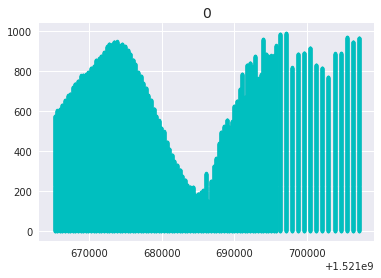

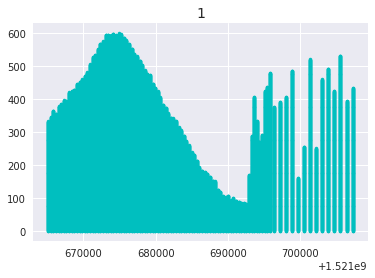

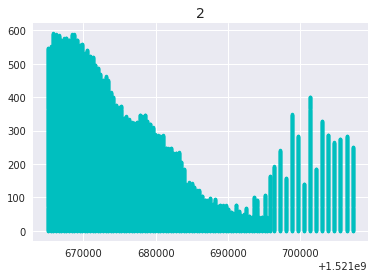

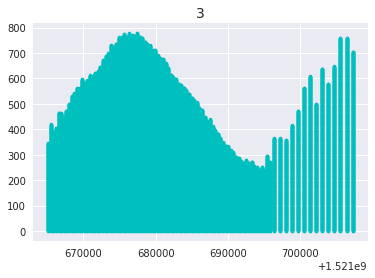

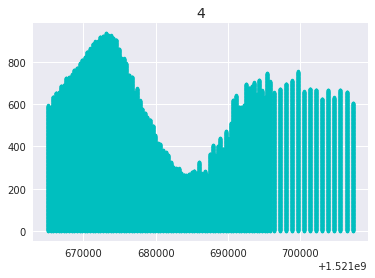

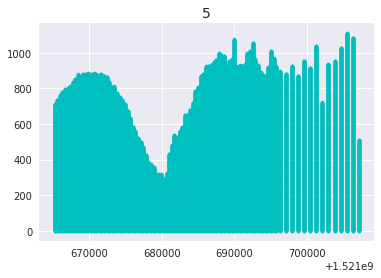

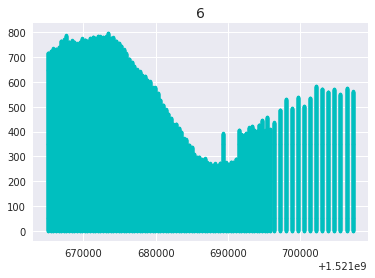

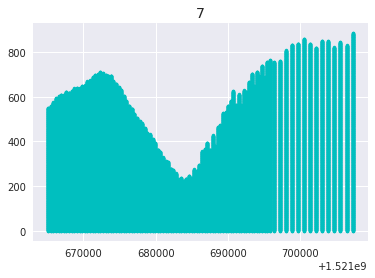

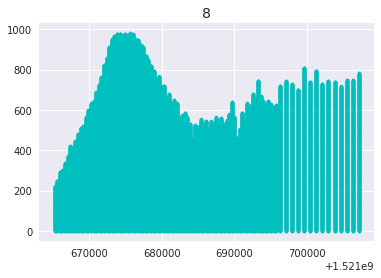

In [6]:
temp = 'processed_part_masktry_{}.csv'
column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn), ignore_index=True)

for i in range(9):
    plt.figure()
    indx = df.pos == i
#     plt.plot(df.time[indx], df.mscarlet[indx],'r.')
    plt.plot(df.time[indx], df.colony[indx],'c.')
    plt.title(i)
#     plt.savefig("fluoro_{}.png".format(i))
#     plt.close('all')
# df.pos

In [ ]:
temp = 'full_image_part{}.csv'
column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn), ignore_index=True)
    
t_min = df.time.min()

def plot_positions(df, pos_list, title, labels):
    fig, axs = plt.subplots(1,2, figsize=(7,4))
    for c_i, channel in enumerate(["mscarlet", "sfcfp"]):
        bg = df.loc[df.pos==1,channel]
        for i in pos_list:
            indx = df.pos == i
            x = (df.time[indx].values - t_min)/3600
            y = df.loc[indx,channel].values - bg.values
            axs[c_i].plot(x,y,'.', label=labels[i])
            axs[c_i].set_title(title)
            axs[c_i].set_xlabel("Time (hours)")
            axs[c_i].set_ylabel("{} fluorescence".format(channel))
            axs[c_i].set_ylim([-10,50])
            axs[c_i].legend(loc=2)
    plt.tight_layout()

labels = 3*["Signal source", "Near", "Far"]
plot_positions(df, np.arange(3), "Inactive senders, pulsers", labels)
plt.savefig('pad1.pdf')
plot_positions(df, np.arange(3,6), "Senders, pulsers", labels)
plt.savefig('pad2.pdf')
plot_positions(df, np.arange(6,9), "Senders, receivers", labels)
plt.savefig('pad3.pdf')


In [ ]:
col_thresh = 0.1
def write_movie_falsecolor(im_arr, im_lab, annotations=None, skip=1):
    plt.close('all')
    
    t_points, h, w, s = im_arr.shape
    frames = t_points // skip
    
    if annotations is None:
        annotations = ["Frame = {}".format(x) for x in range(t_points)]
    
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w, 3])
    fig, axs = plt.subplots(1,1, figsize=(10,8))
    
    # Plot cell densities
    ax = axs
    im = ax.imshow(blank_array, animated=True, vmax=1, vmin=0, interpolation='none')
    #cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(w-87, h-15, "1 cm", fontsize=20, color="white")
    t = ax.text(0.01,0.01, "", fontsize=20, color="white", transform=ax.transAxes)
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w,3))
    def init_fn():
        im.set_array(blank_array)
        t.set_text("")
        return im, t
        
    def animate(i):
        frame_i = i * skip
#         labels = uncrop(label_image(im_arr[frame_i,:,:,2])[0])
        labels = im_lab[i*skip]
        rfp_mask = np.mod(labels,2)==1
        gfp_mask = (np.mod(labels,2)+1==1) - (labels==0)
        cells = (im_arr[frame_i,:,:,2] - 200)/200
        cells[cells < 0] = 0
        cells[cells > 1] = 1
        rfp = (im_arr[frame_i,:,:,0] - np.mean(im_arr[frame_i,:50,-50:,0]))/200
        rfp[rfp < 0] = 0
        rfp[rfp > 1] = 1
        gfp = (im_arr[frame_i,:,:,1] - np.mean(im_arr[frame_i,:50,-50:,0]))/100
        gfp[gfp < 0] = 0
        gfp[gfp > 1] = 1
        for j in range(3):
            frame_arr[:,:,j] = cells / 4
        frame_arr[:,:,0] += 3*rfp_mask*rfp/4
        frame_arr[:,:,1] += 3*gfp_mask*gfp/4
        frame_arr[-10:-5, -109:-5, :] = 1
        im.set_array(frame_arr)
        t.set_text(annotations[i*skip])
        return im, t

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, init_func=init_fn, 
                             frames=np.arange(frames), interval=50,
                            blit=True)
    
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())

t_df = pd.read_csv('time.csv', index_col=0)
start_ind = 26
end_ind = 1026
t_corr_vec = t_df['"Brightfield"'] - t_df['"Brightfield"'].min()
annotations = ["Day {:.1f}".format(x / (24*3600)) for x in t_corr_vec[start_ind:end_ind]]
# anim_fc = write_movie_falsecolor(im_all[start_ind:end_ind,:,:,:], 
#                                  im_labels,
#                                  skip=10, 
#                                  annotations=annotations)
HTML(anim_fc.to_html5_video())

In [ ]:
start_ind = 26
end_ind = 1026
t_corr_vec[start_ind:end_ind].shape

In [ ]:
Writer = anm.writers['imagemagick']
writer = Writer(fps=25, metadata=dict(artist='Me'), bitrate=900)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
for skip in [5, 12, 15, 18]:
    anim_fc = write_movie_falsecolor(im_all[start_ind:end_ind,:,:,:], 
                                     im_lab_t,
                                     skip=skip, 
                                     annotations=annotations)
    anim_fc.save('animation_a3ic1_skip{}.gif'.format(skip), dpi=150, writer=writer)
#plt.close('all')


In [ ]:
for p in jobs:
    p.join()

In [ ]:
def process_control(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'gfp', 'rfp', 'col_size', 'gfp_bg', 'rfp_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, gfps, sizes, num, gfp_bg, rfp_bg = get_fluors(acq_dict['"RFP"'][1], acq_dict['"YFP"'][1], acq_dict['"Brightfield"'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return df

control_types = ['a3u', 'c3ic', 'a3ic2', 'c3u', 'a3ir', 'c3ir']
def par_worker(control_list):
    for cntrl in control_list:
        img_dirs = np.sort([x for x in os.listdir() if os.path.isdir(x) if cntrl in x])
        f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs 
                   for fn in os.listdir(img_dir) 
                   if '.tif' in fn[-4:] if 'convert' not in fn]
        df_list = []
        for fn in f_names:
            df_sub = process_control(fn)
            df_list.append(df_sub)
            print("Writing ", fn)
        df = pd.concat(df_list)
        df.to_csv("{}_processed.csv".format(cntrl))

jobs = []
worker_inputs = [control_types[i::4] for i in range(4)]
for worker_input in worker_inputs:
    p = multiprocessing.Process(target=par_worker,
                                args=(worker_input,))
    jobs.append(p)
    p.start()
    # jobs = []
# for i in [2]:
#     p = multiprocessing.Process(target=par_worker, 
#                                 args=(im_all[i::4,:,:,:].copy(), 
#                                 t_df.iloc[i::4,:].copy(), fn_outs[i]))
#     jobs.append(p)
#     p.start()

# anim = write_movie_falsecolor(all_a3u2, skip=1)
# HTML(anim.to_html5_video())

In [ ]:
data_df = pd.DataFrame(columns=['col_size', 'colony', 'gfp', 'gfp_bg', 'rfp', 'rfp_bg', 'time', 'batch'])
for cntrl in control_types:
    data_df_sub = pd.read_csv("{}_processed.csv".format(cntrl), index_col=0)
    n_rows = data_df_sub.shape[0]
    
    # Add batch 
    lab_vec = np.repeat(cntrl, n_rows)
    label_series = pd.DataFrame({"batch":lab_vec}, index=data_df_sub.index)
    
    # Add rounded time
    hours_vec = np.round((data_df_sub.time.values - epoch_zero)/3600)
    hours_series = pd.DataFrame({"hours":hours_vec}, index=data_df_sub.index)
    
    data_df_joined = data_df_sub.join([label_series, hours_series])
    data_df = data_df.append(data_df_joined)

In [ ]:
#from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.transform import factor_cmap
#from bokeh.plotting import figure

grouped = data_df.groupby(("batch","colony","hours"))
df_agg = grouped.aggregate('median')

source = ColumnDataSource(df_agg)
# index_cmap = factor_cmap('b_c_h', palette=palettes.Category10_10, 
#                          factors=sorted(df.cyl.unique()), end=1)

p = figure(x_range=df_agg, plot_height=800,
           toolbar_location=None, tools="")

p.vbar(x = 'batch_colony_hours', top='gfp', width=0.9, source=source)

# p.y_range.start = 0
# p.x_range.range_padding = 0.1
# p.xaxis.major_label_orientation = 1
# p.xgrid.grid_line_color = None

show(p)

In [ ]:
tmp_fn = lambda x : if x.s
data_df.groupby(('colony', 'hours')).agg('median')

In [ ]:

pal_1 = ['#fdcc8a', '#fc8d59', "#d7301f"]
pal_2 = ['#b2e2e2', '#66c2a4', "#238b45"]
pal_all = []
for i in range(3):
    pal_all.append(pal_1[i])
    pal_all.append(pal_2[i])
palette = pal_all
p1 = figure(width=800,height=800, title="Normalized fluorescence")
p1.background_fill_color ='whitesmoke'
for colid in range(0,6,2):
    indx = (df.colony==colid)
    t_vals = (df.time[indx] -df.time.min()) / 3600 
    y_vals = (df.loc[indx, "rfp"] - df.loc[indx, "rfp_bg"]) 
    p1.circle(t_vals, y_vals,color=palette[colid], legend="Colony {}".format(colid))

for colid in range(1,6,2):
    indx = (df.colony==colid)
    t_vals = (df.time[indx] -df.time.min()) / 3600 
    y_vals = (df.loc[indx, "gfp"] - df.loc[indx, "gfp_bg"])
    p1.circle(t_vals, y_vals,color=palette[colid], legend="Colony {}".format(colid))

p = figure(width=800,height=800)
p.background_fill_color ='lightpink'
for colid in range(0,6,1):
    indx = (df.colony==colid)
    p.circle((df.time[indx] -df.time.min()) / 3600 , df.col_size[indx], color=palette[colid])
#show(p)
p1.legend.location = "top_left"
show(p1)

In [ ]:
# def par_worker(im_arr, t_df, fn_out):
#     column_names = ('time', 'colony', 'gfp', 'rfp', 'col_size', 'gfp_bg', 'rfp_bg')
#     df = pd.DataFrame(columns=column_names)
#     t, h, w, s = im_arr.shape
#     for t_i in range(t):
#         ct = t_df.iloc[t_i, 2]
#         rfps, gfps, sizes, num, gfp_bg, rfp_bg = get_fluors(im_arr[t_i,:,:,0], 
#                                                             im_arr[t_i,:,:,1], 
#                                                             im_arr[t_i,:,:,2])
#         for col_i in range(num):
#             df_dict = dict(zip(column_names, [[ct], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
#             df = df.append(pd.DataFrame(df_dict), ignore_index=True)
#     df.to_csv(fn_out)
#     print("wrote ", fn_out)

# t_df = pd.read_csv('time.csv', index_col=0)
# fn_temp = "processed_part{}.csv"
# fn_outs = [fn_temp.format(i) for i in range(4)]

# jobs = []
# for i in [2]:
#     p = multiprocessing.Process(target=par_worker, 
#                                 args=(im_all[i::4,:,:,:].copy(), 
#                                 t_df.iloc[i::4,:].copy(), fn_outs[i]))
#     jobs.append(p)
#     p.start()


In [ ]:
## Make images of control plates

def make_control_img(im_arr, annotation=""):
    plt.close('all')
    
    t_points, h, w, s = im_arr.shape
    frames = t_points
    
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w, 3])
    fig, axs = plt.subplots(1,1, figsize=(10,8))
    
    # Plot cell densities
    ax = axs
    im = ax.imshow(blank_array, animated=True, vmax=1, vmin=0, interpolation='none')
    #cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(w-90, h-15, "1 cm", fontsize=20, color="white")
    t = ax.text(0.01,0.01, "", fontsize=20, color="white", transform=ax.transAxes)
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w,3))

    frame_i = 0
    labels = uncrop(label_image(im_arr[frame_i,:,:,2])[0])
    rfp_mask = (labels == 1) + (labels == 3) + (labels == 4)
    gfp_mask = (labels == 2) + (labels == 5)
    cells = (im_arr[frame_i,:,:,2] - 200)/200
    cells[cells < 0] = 0
    cells[cells > 1] = 1
    rfp = (im_arr[frame_i,:,:,0] - np.mean(im_arr[frame_i,:50,-50:,0]))/200
    rfp[rfp < 0] = 0
    rfp[rfp > 1] = 1
    gfp = (im_arr[frame_i,:,:,1] - np.mean(im_arr[frame_i,:50,-50:,0]))/100
    gfp[gfp < 0] = 0
    gfp[gfp > 1] = 1
    for j in range(3):
        frame_arr[:,:,j] = cells / 4
    frame_arr[:,:,0] += 3*rfp_mask*rfp/4
    frame_arr[:,:,1] += 3*gfp_mask*gfp/4
    frame_arr[-10:-5, -109:-5, :] = 1
    im.set_array(frame_arr)
    t.set_text(annotation)
    return fig

control_types = ['a3u', 'c3ic', 'a3ic2', 'c3u', 'a3ir', 'c3ir']
control_types = ['c3ic', 'c3u', 'c3ir']
for cntrl in control_types:
    img_dirs = np.sort([x for x in os.listdir() if os.path.isdir(x) if cntrl in x])
    f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs 
               for fn in os.listdir(img_dir) 
               if '.tif' in fn[-4:] if 'convert' not in fn]
    for fn in f_names:
        ct = (get_time_vector_from_fn(fn)['"Brightfield"'][0] - epoch_zero) / (24*3600)
        ann = "Day {:.1f}".format(ct)
        with Image.open(fn) as img:
            channels = ['"RFP"', '"YFP"', '"Brightfield"']
            img_dict, time_dict = get_movie_from_img(img)
            img_len = min([len(time_dict[x]) for x in channels])
            im_arr = np.concatenate([img_dict[channel][:img_len,:,:,:] for channel in channels], axis=3)
        img = skimage.transform.downscale_local_mean(im_arr, (1, 2,2, 1)).astype(np.uint16)
        fig = make_control_img(img, ann)
        fig.savefig("{}.png".format(os.path.dirname(fn)), dpi=400)

In [ ]:
# im_arr = skimage.io.imread('../180206_day0_6pm_a3i/MMStack_Pos0.ome.tif')
# im_arr = skimage.io.imread('../180206_day0_9pm_a3i/MMStack_Pos0.ome.tif')
df_replace.columns

In [ ]:
labld, num = label_image(im_arr[-1,:,:,2])
plt.imshow(labld)
print(num)

In [ ]:
gb = df_replace.groupby("colony")
for i in range(6):
    plt.figure()
    plt.plot((gb.get_group(i).time)/(3600), gb.get_group(i).gfp - gb.get_group(i).gfp_bg,'.')